In [9]:
# Cell 1 — installs (safe to re-run; skip if you already have these)
import sys, subprocess

def pip_install(pkg):
    try:
        __import__(pkg.split("==")[0].split(">=")[0].split("[")[0])
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

for pkg in [
    "torch",
    "torchvision",
    "pandas",
    "scikit-learn",
    "matplotlib",
    "Pillow",
]:
    pip_install(pkg)

print("✅ Environment ready")


✅ Environment ready


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# Cell 2 — imports / constants
from pathlib import Path
import json, os
import pandas as pd
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

from sklearn.model_selection import train_test_split
from collections import Counter


# EfficientNet + weights (torchvision >=0.13 has Weights enums)
from torchvision.models import (
    efficientnet_b0, efficientnet_b1, efficientnet_b2, efficientnet_b3,
    efficientnet_b4, efficientnet_b5, efficientnet_b6, efficientnet_b7,
)
try:
    from torchvision.models import (
        EfficientNet_B0_Weights, EfficientNet_B1_Weights, EfficientNet_B2_Weights,
        EfficientNet_B3_Weights, EfficientNet_B4_Weights, EfficientNet_B5_Weights,
        EfficientNet_B6_Weights, EfficientNet_B7_Weights,
    )
    WEIGHTS_AVAILABLE = True
except Exception:
    WEIGHTS_AVAILABLE = False

# >>>>> YOUR PATHS <<<<<
IMG_DIR  = Path("/content/drive/MyDrive/data/s_1024")
CSV_PATH = Path("/content/drive/MyDrive/data/streetSurfaceVis_v1_0_2.csv")

OUT_DIR = Path("./outputs_streetsurfacevis")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Device selection (CUDA if present, then Apple MPS, else CPU)
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

DEVICE



device(type='cuda')

In [12]:
# Cell 3 — read CSV and detect filename + master/subclass columns (robust)
import re

df = pd.read_csv(CSV_PATH)
print("CSV columns:", list(df.columns))
display(df.head())

# ===== OPTIONAL MANUAL OVERRIDES (set to strings if you know them) =====
FILENAME_COL_OVERRIDE = None   # e.g. "image_path" or "filename"
MASTER_COL_OVERRIDE   = None   # e.g. "surface_type"
SUB_COL_OVERRIDE      = None   # e.g. "damage_type"
# ======================================================================

# Build a case-insensitive lookup: lower_name -> actual_name
lower2actual = {c.lower(): c for c in df.columns}

def find_col(candidates):
    for alias in candidates:
        if alias.lower() in lower2actual:
            return lower2actual[alias.lower()]
    return None

# 1) Filename column
if FILENAME_COL_OVERRIDE:
    FILENAME_COL = FILENAME_COL_OVERRIDE
else:
    FILENAME_CANDIDATES = [
        "filepath","file_path","path","image_path","image","img","filename","file",
        "name","relative_path","relpath","full_path","abs_path","image_name","image_id"
    ]
    FILENAME_COL = find_col(FILENAME_CANDIDATES)

# 2) Master + Subclass columns (prefer explicit two columns)
if MASTER_COL_OVERRIDE:
    MASTER_COL = MASTER_COL_OVERRIDE
else:
    MASTER_CANDS = [
        "master","surface","surface_type","surface_class","coarse","coarse_label",
        "superclass","top_class","type","road_type","material","parent_class"
    ]
    MASTER_COL = find_col(MASTER_CANDS)

if SUB_COL_OVERRIDE:
    SUB_COL = SUB_COL_OVERRIDE
else:
    SUB_CANDS = [
        "subclass","sub","sub_type","subclass_label","fine","fine_label","subcategory",
        "damage","damage_type","condition","defect","pattern"
    ]
    SUB_COL = find_col(SUB_CANDS)

# 3) If we didn't find both, try to split a single combined label col (e.g., "label" or "class")
COMBINED_COL = None
if MASTER_COL is None or SUB_COL is None:
    COMBINED_CANDS = ["label","labels","class","classes","category","target","fine_label","master_sub"]
    COMBINED_COL = find_col(COMBINED_CANDS)

    if COMBINED_COL is not None:
        # Try to split with common delimiters: "/", " - ", ">", "|", ":", ";"
        def split_pair(s):
            if not isinstance(s, str):
                s = str(s)
            # first try "/", then others
            for pat in [r"/", r"\s*-\s*", r"\s*>\s*", r"\|", r":", r";"]:
                parts = re.split(pat, s, maxsplit=1)
                if len(parts) == 2:
                    return parts[0].strip(), parts[1].strip()
            return s.strip(), None  # couldn't split

        m_vals, s_vals = [], []
        for v in df[COMBINED_COL].astype(str).fillna(""):
            m, s = split_pair(v)
            m_vals.append(m)
            s_vals.append(s)
        df["__master_tmp"] = m_vals
        df["__sub_tmp"]    = s_vals

        # If many subs are None, assume only master provided
        if pd.Series(s_vals).notna().mean() < 0.5:
            SUB_COL = None
        else:
            SUB_COL = "__sub_tmp"
        MASTER_COL = "__master_tmp"

# 4) Final checks
if FILENAME_COL is None:
    raise ValueError(
        "Could not detect a filename column. Set FILENAME_COL_OVERRIDE to the correct column name."
    )
if MASTER_COL is None:
    raise ValueError(
        "Could not detect a master-class column. Set MASTER_COL_OVERRIDE or provide a combined label column I can split."
    )

# If subclass truly missing, we’ll proceed with master only; otherwise we have both.
print(f"Detected filename column: {FILENAME_COL!r}")
print(f"Detected master column:   {MASTER_COL!r}")
print(f"Detected subclass column: {SUB_COL!r}")

# Basic stats
print("\nMaster label counts:")
display(df[MASTER_COL].value_counts().to_frame("count"))

if SUB_COL is not None:
    print("\nSubclass label counts (top 20):")
    display(df[SUB_COL].value_counts().head(20).to_frame("count"))

# Keep these vars for later cells
FILENAME_COL = FILENAME_COL
MASTER_COL   = MASTER_COL
SUB_COL      = SUB_COL


CSV columns: ['mapillary_image_id', 'path', 'filepath', 'user_id', 'user_name', 'captured_at', 'longitude', 'latitude', 'train', 'type', 'surface_quality']


,mapillary_image_id,path,filepath,user_id,user_name,captured_at,longitude,latitude,train,type,surface_quality
0,1000927687276860,/content/drive/MyDrive/data/s_1024,/content/drive/MyDrive/data/s_1024/10009276872...,103606985215406,dsmm,1655735677353,13.287805,51.502597,True,concrete,intermediate
1,1001349260556407,/content/drive/MyDrive/data/s_1024,/content/drive/MyDrive/data/s_1024/10013492605...,102468835332129,ber319,1659015876793,14.426536,52.217757,True,unpaved,bad
2,1001419624308587,/content/drive/MyDrive/data/s_1024,/content/drive/MyDrive/data/s_1024/10014196243...,100232345559807,carlheinz,1698249177500,13.457938,52.512914,True,asphalt,good
3,1001712924422413,/content/drive/MyDrive/data/s_1024,/content/drive/MyDrive/data/s_1024/10017129244...,100232345559807,carlheinz,1699107239000,13.386874,52.564970,True,concrete,excellent
4,1001853784055707,/content/drive/MyDrive/data/s_1024,/content/drive/MyDrive/data/s_1024/10018537840...,102627028648372,kartonage,1652268883000,13.389880,52.546260,True,asphalt,excellent


Detected filename column: 'filepath'
Detected master column:   'type'
Detected subclass column: None

Master label counts:


,count
type,
asphalt,3734
paving_stones,2037
sett,1363
unpaved,1016
concrete,972


In [13]:
# Cell 4 — index image files for robust resolution
from tqdm import tqdm

def index_images(root: Path):
    idx = {}
    # You can restrict extensions if needed
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}
    for p in tqdm(list(root.rglob("*")), desc=f"Indexing {root}"):
        if p.is_file() and p.suffix.lower() in exts:
            idx.setdefault(p.name, []).append(p)
    return idx

basename_index = index_images(IMG_DIR)
print(f"Indexed {sum(len(v) for v in basename_index.values())} images. "
      f"Unique basenames: {len(basename_index)}")


Indexing /content/drive/MyDrive/data/s_1024: 100%|██████████| 9122/9122 [00:00<00:00, 10621.84it/s]

Indexed 9122 images. Unique basenames: 9122


In [14]:
# Cell 5 — resolve paths
def resolve_path(row):
    raw = str(row[FILENAME_COL]).strip()
    candidate = IMG_DIR / raw
    if candidate.exists():
        return candidate
    # Fallback: try basename search
    base = os.path.basename(raw)
    hits = basename_index.get(base, [])
    if len(hits) == 1:
        return hits[0]
    elif len(hits) > 1:
        # If duplicates, prefer the one with longest common suffix match
        # (you can customize; for now pick the first deterministically)
        return sorted(hits, key=lambda p: len(str(p)))[0]
    return None

df["resolved_path"] = df.apply(resolve_path, axis=1)
missing = df["resolved_path"].isna().sum()
print(f"Unresolved rows: {missing}")

# Drop rows without files
df = df.dropna(subset=["resolved_path"]).reset_index(drop=True)
print(f"Usable rows after drop: {len(df)}")



Unresolved rows: 0
Usable rows after drop: 9122


In [15]:
# Cell 6 — encode *fine* labels (auto-detect SUB_COL if needed)
from collections import Counter

if MASTER_COL is None:
    raise ValueError(
        "MASTER_COL is None. Go back to Cell 3 and set MASTER_COL_OVERRIDE to your master label column."
    )

# Try to auto-detect SUB_COL if missing
if SUB_COL is None:
    print("[info] SUB_COL is None — attempting to auto-detect subclass column...")

    # 1) Try by common subclass-ish names
    SUB_NAME_HINTS = [
        "subclass","sub","sub_type","subclass_label","fine","fine_label",
        "subcategory","damage","damage_type","condition","defect","pattern",
        "severity","level","class2","subcat","child","detail"
    ]
    lower2actual = {c.lower(): c for c in df.columns}
    for k in SUB_NAME_HINTS:
        if k.lower() in lower2actual and lower2actual[k.lower()] != MASTER_COL:
            SUB_COL = lower2actual[k.lower()]
            print(f"[auto] Using subclass column by name: {SUB_COL!r}")
            break

    # 2) If still not found, try by cardinality (prefer 5 unique values)
    if SUB_COL is None:
        candidates = []
        for c in df.columns:
            if c in {FILENAME_COL, MASTER_COL}:
                continue
            nun = df[c].nunique(dropna=True)
            # look for small categorical columns
            if 2 <= nun <= 10:
                candidates.append((c, nun))
        # Prefer nunique closest to 5, then smaller nunique
        candidates.sort(key=lambda x: (abs(x[1] - 5), x[1]))
        if candidates:
            SUB_COL = candidates[0][0]
            print(f"[auto] Using subclass column by cardinality: {SUB_COL!r} (unique={df[SUB_COL].nunique()})")

    if SUB_COL is None:
        raise ValueError(
            "Could not determine SUB_COL automatically. "
            "Set SUB_COL_OVERRIDE in Cell 3 to your subclass column and re-run."
        )

# Sanity stats for master/sub
print("Master unique:", df[MASTER_COL].nunique(), "| Subclass unique:", df[SUB_COL].nunique())
print("Master counts:")
display(df[MASTER_COL].value_counts().to_frame("count").head(10))
print("Subclass counts:")
display(df[SUB_COL].value_counts().to_frame("count").head(10))

# Build a combined fine label (e.g., 'asphalt/crack')
df["fine_label"] = df[MASTER_COL].astype(str).fillna("UNK") + "/" + df[SUB_COL].astype(str).fillna("UNK")

# Classes & mappings
classes = sorted(df["fine_label"].unique())
cls_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_cls = {i: c for i, c in enumerate(classes)}

df["label_idx"] = df["fine_label"].map(cls_to_idx)

# Save mapping
(OUT_DIR / "classes_fine.json").write_text(json.dumps(idx_to_cls, indent=2))
print(f"Num fine classes: {len(classes)}  (expect ~25 if 5x5)")
print("Saved mapping to:", OUT_DIR / "classes_fine.json")


[info] SUB_COL is None — attempting to auto-detect subclass column...
[auto] Using subclass column by cardinality: 'surface_quality' (unique=5)
Master unique: 5 | Subclass unique: 5
Master counts:


,count
type,
asphalt,3734
paving_stones,2037
sett,1363
unpaved,1016
concrete,972


Subclass counts:


,count
surface_quality,
good,3238
intermediate,2610
excellent,1670
bad,1301
very_bad,303


Num fine classes: 18  (expect ~25 if 5x5)
Saved mapping to: outputs_streetsurfacevis/classes_fine.json


from matplotlib import pyplot as plt
_df_0['count'].plot(kind='hist', bins=20, title='count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['count'].plot(kind='line', figsize=(8, 4), title='count')
plt.gca().spines[['top', 'right']].set_visible(False)

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [16]:
# Cell 7 — stratified split
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label_idx"]
)
print(f"Train: {len(train_df)} | Val: {len(val_df)}")
print("Train distribution:", Counter(train_df["label_idx"]))
print("Val distribution:", Counter(val_df["label_idx"]))


Train: 7297 | Val: 1825
Train distribution: Counter({2: 1357, 10: 850, 1: 777, 3: 657, 14: 555, 12: 432, 11: 415, 15: 310, 9: 308, 6: 280, 16: 261, 5: 251, 17: 242, 7: 200, 0: 197, 13: 103, 8: 56, 4: 46})
Val distribution: Counter({2: 339, 10: 213, 1: 194, 3: 164, 14: 139, 12: 108, 11: 104, 15: 77, 9: 77, 6: 70, 16: 65, 5: 63, 17: 61, 7: 50, 0: 49, 13: 26, 8: 14, 4: 12})


In [17]:
# Cell 8 — custom Dataset
class CSVDataset(Dataset):
    def __init__(self, frame: pd.DataFrame, transform=None):
        self.frame = frame.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.frame)

    def __getitem__(self, idx):
        row = self.frame.iloc[idx]
        img_path = Path(row["resolved_path"])
        img = Image.open(img_path).convert("RGB")
        label = int(row["label_idx"])
        if self.transform:
            img = self.transform(img)
        return img, label


In [18]:
# Cell 9 — simple augmentations + loaders (REPLACE your current Cell 9)

# ----- model + weights (kept so Cell 10 works unchanged) -----
MODEL_NAME = "efficientnet_b0"   # b0..b7
USE_PRETRAINED = True

MODEL_FNS = {
    "efficientnet_b0": efficientnet_b0,
    "efficientnet_b1": efficientnet_b1,
    "efficientnet_b2": efficientnet_b2,
    "efficientnet_b3": efficientnet_b3,
    "efficientnet_b4": efficientnet_b4,
    "efficientnet_b5": efficientnet_b5,
    "efficientnet_b6": efficientnet_b6,
    "efficientnet_b7": efficientnet_b7,
}

WEIGHTS_ENUM = {
    "efficientnet_b0": EfficientNet_B0_Weights.IMAGENET1K_V1 if WEIGHTS_AVAILABLE else None,
    "efficientnet_b1": EfficientNet_B1_Weights.IMAGENET1K_V2 if WEIGHTS_AVAILABLE else None,
    "efficientnet_b2": EfficientNet_B2_Weights.IMAGENET1K_V1 if WEIGHTS_AVAILABLE else None,
    "efficientnet_b3": EfficientNet_B3_Weights.IMAGENET1K_V1 if WEIGHTS_AVAILABLE else None,
    "efficientnet_b4": EfficientNet_B4_Weights.IMAGENET1K_V1 if WEIGHTS_AVAILABLE else None,
    "efficientnet_b5": EfficientNet_B5_Weights.IMAGENET1K_V1 if WEIGHTS_AVAILABLE else None,
    "efficientnet_b6": EfficientNet_B6_Weights.IMAGENET1K_V1 if WEIGHTS_AVAILABLE else None,
    "efficientnet_b7": EfficientNet_B7_Weights.IMAGENET1K_V1 if WEIGHTS_AVAILABLE else None,
}

weights = WEIGHTS_ENUM.get(MODEL_NAME, None) if USE_PRETRAINED else None

# ----- Albumentations (install if missing) -----
import sys, subprocess
def _pip_install(pkg):
    try: __import__(pkg.split("==")[0].split(">=")[0].split("[")[0])
    except Exception: subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

try:
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
except Exception:
    _pip_install("albumentations>=1.4.6")
    _pip_install("opencv-python-headless>=4.8")
    import albumentations as A
    from albumentations.pytorch import ToTensorV2

import numpy as np
from PIL import Image
from torch.utils.data import DataLoader, Dataset

# ImageNet stats (or pull from weights.meta if available)
if weights is not None and hasattr(weights, "meta"):
    mean = tuple(weights.meta.get("mean", (0.485, 0.456, 0.406)))
    std  = tuple(weights.meta.get("std",  (0.229, 0.224, 0.225)))
else:
    mean = (0.485, 0.456, 0.406)
    std  = (0.229, 0.224, 0.225)

# ----- EXACT transforms you requested -----
train_aug = A.Compose([
    A.Rotate(limit=(2, 20), p=1.0),
    A.GaussNoise(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.Blur(blur_limit=3, p=0.3),
    A.Resize(288, 512),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

val_aug = A.Compose([
    A.Resize(288, 512),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

# ----- Minimal dataset that returns (original + 3 augs) with SAME label -----
class CSVDatasetAlbSimple(Dataset):
    """
    For each row in frame, length is (1 + n_aug).
    k==0 -> 'original' (deterministic val_aug), k>0 -> random train_aug.
    Returns (tensor, label_idx).
    """
    def __init__(self, frame, n_aug: int = 3):
        self.df = frame.reset_index(drop=True)
        self.n_aug = int(n_aug)
        self.copies = 1 + self.n_aug

    def __len__(self):
        return len(self.df) * self.copies

    def __getitem__(self, idx):
        base_idx, k = divmod(idx, self.copies)
        row = self.df.iloc[base_idx]
        img = Image.open(row["resolved_path"]).convert("RGB")
        img_np = np.array(img)

        aug = val_aug if k == 0 else train_aug
        x = aug(image=img_np)["image"]       # C×H×W float tensor
        y = int(row["label_idx"])            # label carried through (fine class if you built it)

        return x, y

# ----- Build loaders -----
N_AUG = 3  # exactly three random augmentations per image

train_ds = CSVDatasetAlbSimple(train_df, n_aug=N_AUG)
val_ds   = CSVDatasetAlbSimple(val_df,   n_aug=0)   # no aug on val

# Smaller batch sizes are safer on MPS; bump on CUDA if you have room
BATCH_SIZE_TRAIN = 8
BATCH_SIZE_VAL   = 8
NUM_WORKERS      = 0
PIN_MEMORY       = (DEVICE.type == "cuda")

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE_TRAIN, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE_VAL,   shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

len(train_ds), len(val_ds)


(29188, 1825)

In [19]:
# Model init
NUM_CLASSES = len(classes)

# Build model with (optional) weights enum already resolved in your code
model = MODEL_FNS[MODEL_NAME](weights=weights)

# Replace classifier head robustly
if hasattr(model, "classifier"):
    # Find the last Linear inside the classifier sequential/container
    last_linear = None
    last_name = None
    for name, module in model.classifier.named_modules():
        if isinstance(module, nn.Linear):
            last_linear, last_name = module, name
    if last_linear is None:
        # Fallback: try the common [-1] pattern
        in_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_features, NUM_CLASSES)
    else:
        # Navigate to parent of the last linear and replace it
        parent = model.classifier
        *path, attr = last_name.split(".")
        for p in path:
            parent = getattr(parent, p)
        setattr(parent, attr, nn.Linear(last_linear.in_features, NUM_CLASSES))
else:
    # Generic fallback if API changes
    last_linear = None
    last_name = None
    for name, module in reversed(list(model.named_modules())):
        if isinstance(module, nn.Linear):
            last_linear, last_name = module, name
            break
    if last_linear is None:
        raise RuntimeError("Could not find a linear classification layer to replace.")
    parent = model
    *path, attr = last_name.split(".")
    for p in path:
        parent = getattr(parent, p)
    setattr(parent, attr, nn.Linear(last_linear.in_features, NUM_CLASSES))

model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()

# Optional: fused AdamW on CUDA for a small speed bump
adamw_kwargs = {}
if DEVICE.type == "cuda":
    try:
        adamw_kwargs["fused"] = True
    except TypeError:
        pass  # older PyTorch without fused AdamW
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, **adamw_kwargs)

best_acc = 0.0
BEST_PATH = OUT_DIR / f"{MODEL_NAME}_best.pth"

print(f"Model: {MODEL_NAME} | Classes: {NUM_CLASSES} | Device: {DEVICE}")


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 134MB/s] 


Model: efficientnet_b0 | Classes: 18 | Device: cuda


In [20]:
# Cell 11 - Evaluate + train with gradient accumulation (compatible with MPS/CPU/CUDA)
import torch
from torch import nn

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    correct = total = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return correct / max(1, total)

def train_one_epoch(model, loader, optimizer, device, criterion: nn.Module, accum_steps: int = 1):
    """
    Train for one epoch with optional gradient accumulation.
    - CUDA: uses AMP (torch.amp) automatically
    - MPS/CPU: FP32 (no AMP)
    """
    model.train()
    running = 0.0
    optimizer.zero_grad(set_to_none=True)

    use_cuda_amp = (device.type == "cuda" and torch.cuda.is_available())
    if use_cuda_amp:
        from torch.amp import autocast, GradScaler
        scaler = GradScaler("cuda")

    for step, (imgs, labels) in enumerate(loader):
        imgs, labels = imgs.to(device), labels.to(device)

        if use_cuda_amp:
            with autocast("cuda"):
                logits = model(imgs)
                loss = criterion(logits, labels) / accum_steps
            scaler.scale(loss).backward()
            if (step + 1) % accum_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
                torch.cuda.empty_cache()
        else:
            logits = model(imgs)
            loss = criterion(logits, labels) / accum_steps
            loss.backward()
            if (step + 1) % accum_steps == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                if device.type == "mps":
                    torch.mps.empty_cache()

        running += loss.item() * accum_steps * labels.size(0)

    return running / max(1, len(loader.dataset))


In [21]:
# Cell 12 — training with robust checkpoints (best/last/every N) + resume-ready state
import torch
from pathlib import Path

CHECKPOINT_DIR = OUT_DIR / "checkpoints"
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

BEST_PATH = CHECKPOINT_DIR / "best.pth"
LAST_PATH = CHECKPOINT_DIR / "last.pth"
STATE_PATH = OUT_DIR / "training_state.pth"
SAVE_PERIOD = 5  # also keep epoch_005, epoch_010, ...

EPOCHS = 10
ACCUM_STEPS = 4  # works with the MPS-friendly train_one_epoch I gave earlier

# If you want to resume, set this True and ensure files exist
RESUME = False

start_epoch = 1
best_acc = 0.0

# ---- Resume logic ----
if RESUME and STATE_PATH.exists() and LAST_PATH.exists():
    print("Resuming from:", STATE_PATH)
    state = torch.load(STATE_PATH, map_location=DEVICE)
    model.load_state_dict(torch.load(LAST_PATH, map_location=DEVICE)["model"])
    optimizer.load_state_dict(state["optimizer"])
    start_epoch = state["epoch"] + 1
    best_acc = state.get("best_acc", 0.0)
    print(f"Resumed at epoch {start_epoch} with best_acc={best_acc:.4f}")

for epoch in range(start_epoch, EPOCHS + 1):
    tr_loss = train_one_epoch(model, train_loader, optimizer, DEVICE, criterion, accum_steps=ACCUM_STEPS)
    val_acc = evaluate(model, val_loader, DEVICE)

    # Save LAST every epoch
    torch.save({"model": model.state_dict(),
                "classes": idx_to_cls,
                "model_name": MODEL_NAME}, LAST_PATH)

    # Save periodic epoch checkpoint
    if epoch % SAVE_PERIOD == 0:
        torch.save({"model": model.state_dict(),
                    "classes": idx_to_cls,
                    "model_name": MODEL_NAME},
                   CHECKPOINT_DIR / f"epoch_{epoch:03d}.pth")

    # Save BEST if improved
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({"model": model.state_dict(),
                    "classes": idx_to_cls,
                    "model_name": MODEL_NAME}, BEST_PATH)

    # Save training state for resume (optimizer + epoch + best_acc)
    torch.save({
        "epoch": epoch,
        "best_acc": best_acc,
        "optimizer": optimizer.state_dict(),
    }, STATE_PATH)

    print(f"Epoch {epoch:03d}/{EPOCHS} | train_loss={tr_loss:.4f} | val_acc={val_acc:.4f}"
          + ("  <-- best" if val_acc == best_acc else ""))

    if DEVICE.type == "mps":
        torch.mps.empty_cache()

print(f"✅ Done. Best val_acc={best_acc:.4f}")
print(f"Best: {BEST_PATH.name} | Last: {LAST_PATH.name} | State: {STATE_PATH.name}")


Epoch 001/10 | train_loss=1.5080 | val_acc=0.5847  <-- best
Epoch 002/10 | train_loss=1.0721 | val_acc=0.5907  <-- best
Epoch 003/10 | train_loss=0.8182 | val_acc=0.5836
Epoch 004/10 | train_loss=0.6134 | val_acc=0.5830
Epoch 005/10 | train_loss=0.4544 | val_acc=0.5710
Epoch 006/10 | train_loss=0.3591 | val_acc=0.5512
Epoch 007/10 | train_loss=0.2870 | val_acc=0.5255
Epoch 008/10 | train_loss=0.2357 | val_acc=0.5403
Epoch 009/10 | train_loss=0.2162 | val_acc=0.5386
Epoch 010/10 | train_loss=0.1842 | val_acc=0.5441
✅ Done. Best val_acc=0.5907
Best: best.pth | Last: last.pth | State: training_state.pth


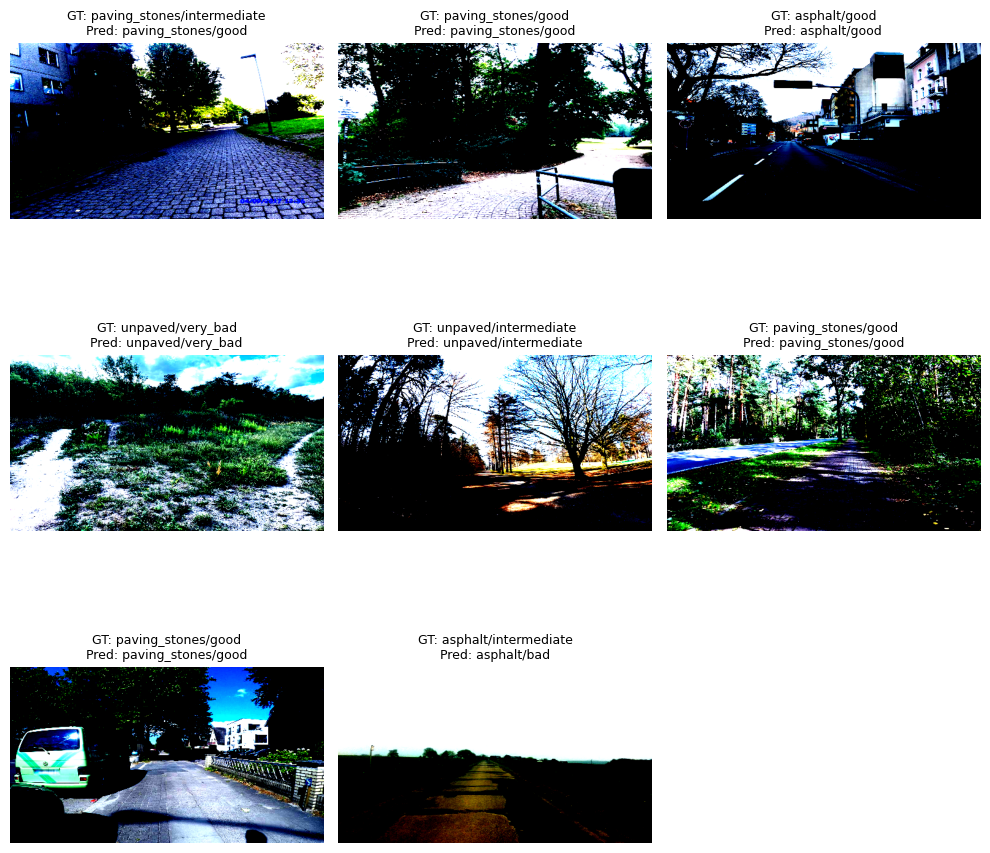

In [22]:
# Cell 13 — visualize predictions with master/subclass
import matplotlib.pyplot as plt
import numpy as np

model.eval()
imgs, labels = next(iter(val_loader))
with torch.no_grad():
    logits = model(imgs.to(DEVICE))
    preds = logits.argmax(1).cpu().numpy()

plt.figure(figsize=(10, 10))
n = min(9, len(imgs))
for i in range(n):
    ax = plt.subplot(3, 3, i+1)
    im = imgs[i].permute(1,2,0).numpy()
    im = np.clip(im, 0, 1)
    plt.imshow(im)

    gt_fine = idx_to_cls[int(labels[i].item())]
    pr_fine = idx_to_cls[int(preds[i])]
    gt_master, gt_sub = gt_fine.split("/", 1)
    pr_master, pr_sub = pr_fine.split("/", 1)

    ax.set_title(f"GT: {gt_master}/{gt_sub}\nPred: {pr_master}/{pr_sub}", fontsize=9)
    ax.axis("off")
plt.tight_layout()
plt.show()


In [23]:
# Extra cell — fine vs coarse accuracy
@torch.no_grad()
def coarse_fine_accuracy(model, loader, device):
    model.eval()
    fine_correct = fine_total = 0
    coarse_correct = coarse_total = 0

    for imgs, labels in loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        preds = logits.argmax(1).cpu().numpy()
        labels_np = labels.numpy()

        # Fine accuracy
        fine_correct += (preds == labels_np).sum()
        fine_total   += len(labels_np)

        # Coarse accuracy: compare master parts only
        pred_master  = [idx_to_cls[int(p)].split("/", 1)[0] for p in preds]
        label_master = [idx_to_cls[int(t)].split("/", 1)[0] for t in labels_np]
        coarse_correct += sum(pm == lm for pm, lm in zip(pred_master, label_master))
        coarse_total   += len(labels_np)

    return fine_correct / max(1, fine_total), coarse_correct / max(1, coarse_total)

fine_acc, coarse_acc = coarse_fine_accuracy(model, val_loader, DEVICE)
print(f"Fine (25-class) acc:   {fine_acc:.4f}")
print(f"Coarse (5-class) acc:  {coarse_acc:.4f}")


Fine (25-class) acc:   0.5441
Coarse (5-class) acc:  0.8729


In [24]:
from PIL import Image, ImageOps
from pathlib import Path

# Pick any image path:
# 1) from your dataframe (recommended)
p = Path(df.loc[0, "resolved_path"]) if "resolved_path" in df.columns else None

# 2) or hardcode a path if needed:
# p = Path("/Users/BalqisHebat/Downloads/s_1024/some_image.jpg")

assert p is not None and p.exists(), f"Image not found: {p}"

with Image.open(p) as im:
    w, h = im.size  # stored size (no EXIF transpose)
    w2, h2 = ImageOps.exif_transpose(im).size  # display size after applying EXIF orientation
    print(f"Stored size:  {w} x {h}")
    print(f"Display size: {w2} x {h2}  (after EXIF)")
    print(f"Format: {im.format}  Mode: {im.mode}")


Stored size:  1024 x 576
Display size: 1024 x 576  (after EXIF)
Format: JPEG  Mode: RGB


In [25]:
# Cell 14 — list saved files
from pathlib import Path
for p in sorted(OUT_DIR.glob("*")):
    print(p.name, p.stat().st_size, "bytes")


checkpoints 4096 bytes
classes_fine.json 497 bytes
training_state.pth 32429028 bytes


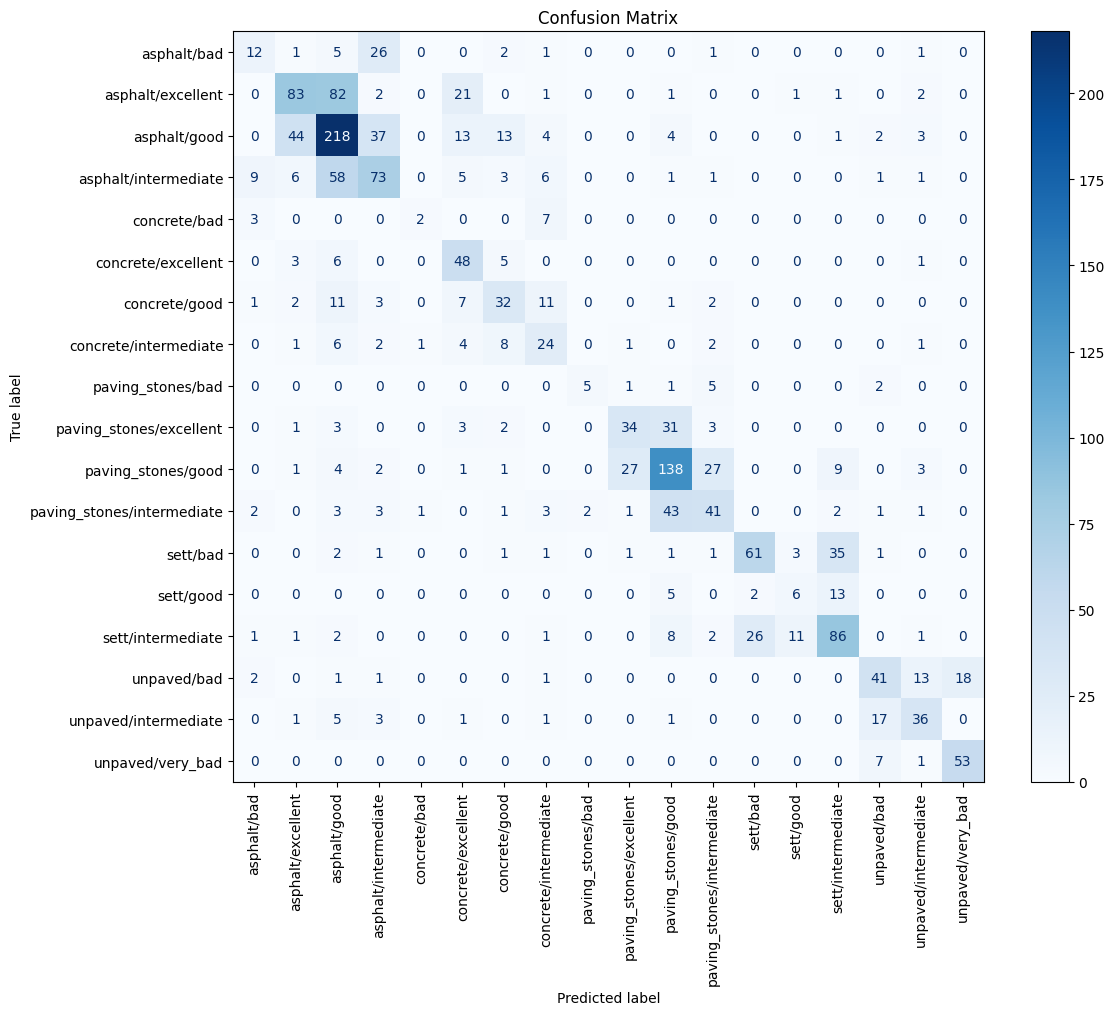

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Collect all true and predicted labels
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        logits = model(imgs)
        preds = logits.argmax(1).cpu().numpy()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds)

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Get class names in the correct order
class_names = [idx_to_cls[i] for i in sorted(idx_to_cls.keys())]

# Display confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [28]:
# Calculate accuracy for each class from the confusion matrix
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Print the accuracy for each class
print("Accuracy for each class:")
for i, class_name in enumerate(class_names):
    print(f"- {class_name}: {class_accuracies[i]:.4f}")

Accuracy for each class:
- asphalt/bad: 0.2449
- asphalt/excellent: 0.4278
- asphalt/good: 0.6431
- asphalt/intermediate: 0.4451
- concrete/bad: 0.1667
- concrete/excellent: 0.7619
- concrete/good: 0.4571
- concrete/intermediate: 0.4800
- paving_stones/bad: 0.3571
- paving_stones/excellent: 0.4416
- paving_stones/good: 0.6479
- paving_stones/intermediate: 0.3942
- sett/bad: 0.5648
- sett/good: 0.2308
- sett/intermediate: 0.6187
- unpaved/bad: 0.5325
- unpaved/intermediate: 0.5538
- unpaved/very_bad: 0.8689


In [27]:
from sklearn.metrics import accuracy_score, f1_score

# Assuming all_labels and all_preds are available from the confusion matrix cell

# Accuracy (already calculated in a021d068-7fb0-48dc-8571-3eba23c1c916, but recalculating here for completeness)
fine_acc = accuracy_score(all_labels, all_preds)

# F1-score (macro average is often a good choice for multi-class)
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Fine (18-class) Accuracy: {fine_acc:.4f}")
print(f"Macro F1-score:         {f1:.4f}")

Fine (18-class) Accuracy: 0.5441
Macro F1-score:         0.4977


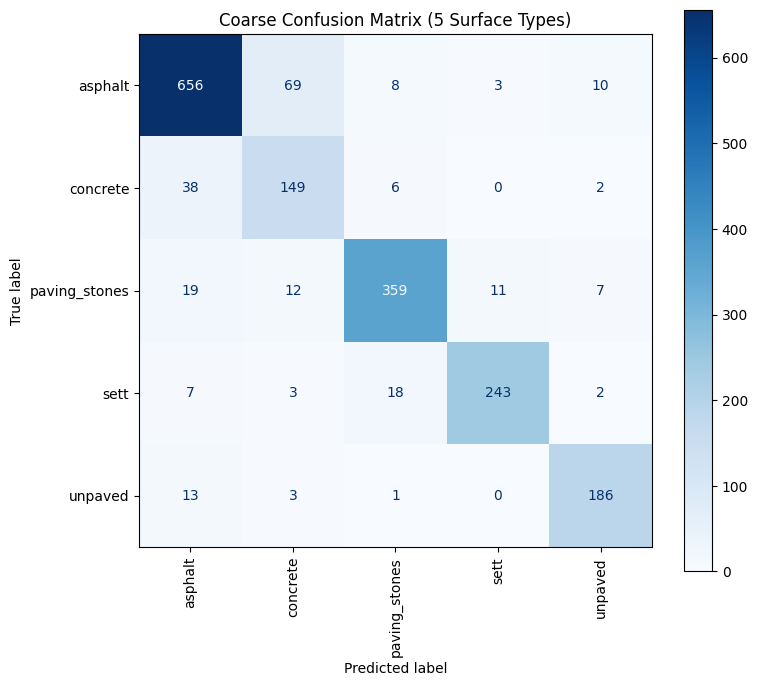

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Assuming all_labels and all_preds are available from the fine-grained confusion matrix cell

# Map fine-grained indices back to fine-grained class names
fine_label_names = [idx_to_cls[i] for i in sorted(idx_to_cls.keys())]

# Extract coarse master labels from the fine-grained names
# This assumes fine_label_names are in the format "master/sub"
true_coarse_labels = [label.split('/')[0] for label in [fine_label_names[i] for i in all_labels]]
pred_coarse_labels = [label.split('/')[0] for label in [fine_label_names[i] for i in all_preds]]

# Get the unique coarse class names in a defined order (matching the order in df)
coarse_class_names = sorted(df[MASTER_COL].unique())

# Convert coarse string labels to integer indices for confusion_matrix
coarse_name_to_idx = {name: i for i, name in enumerate(coarse_class_names)}
true_coarse_indices = [coarse_name_to_idx[label] for label in true_coarse_labels]
pred_coarse_indices = [coarse_name_to_idx[label] for label in pred_coarse_labels]


# Generate confusion matrix for coarse classes
cm_coarse = confusion_matrix(true_coarse_indices, pred_coarse_indices)

# Display confusion matrix
fig, ax = plt.subplots(figsize=(8, 7))
disp_coarse = ConfusionMatrixDisplay(confusion_matrix=cm_coarse, display_labels=coarse_class_names)
disp_coarse.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Coarse Confusion Matrix (5 Surface Types)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

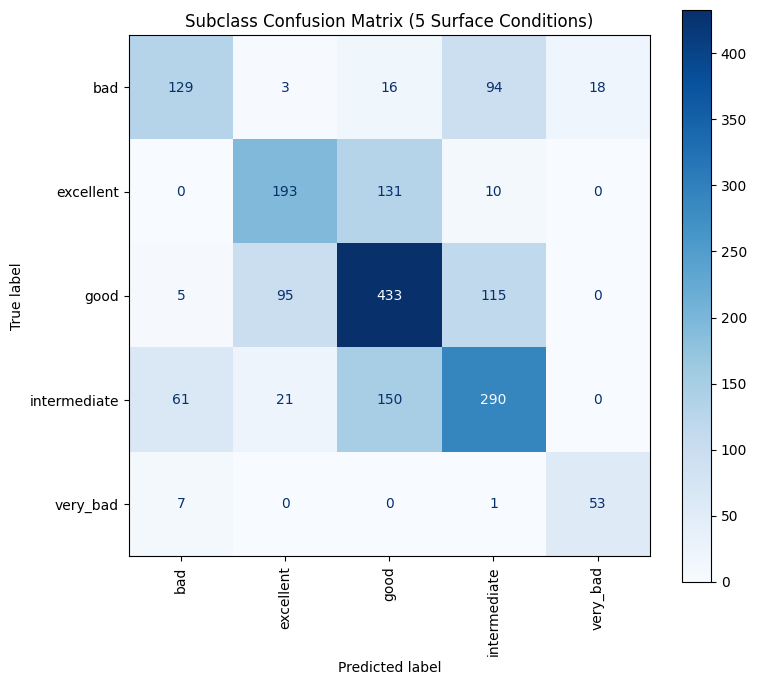

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Assuming all_labels and all_preds are available from the fine-grained confusion matrix cell

# Map fine-grained indices back to fine-grained class names
fine_label_names = [idx_to_cls[i] for i in sorted(idx_to_cls.keys())]

# Extract subclass labels from the fine-grained names
# This assumes fine_label_names are in the format "master/sub"
true_sub_labels = [label.split('/')[1] for label in [fine_label_names[i] for i in all_labels]]
pred_sub_labels = [label.split('/')[1] for label in [fine_label_names[i] for i in all_preds]]

# Get the unique subclass names in a defined order (matching the order in df)
sub_class_names = sorted(df[SUB_COL].unique())

# Convert subclass string labels to integer indices for confusion_matrix
sub_name_to_idx = {name: i for i, name in enumerate(sub_class_names)}
true_sub_indices = [sub_name_to_idx[label] for label in true_sub_labels]
pred_sub_indices = [sub_name_to_idx[label] for label in pred_sub_labels]


# Generate confusion matrix for subclass labels
cm_sub = confusion_matrix(true_sub_indices, pred_sub_indices)

# Display confusion matrix
fig, ax = plt.subplots(figsize=(8, 7))
disp_sub = ConfusionMatrixDisplay(confusion_matrix=cm_sub, display_labels=sub_class_names)
disp_sub.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Subclass Confusion Matrix (5 Surface Conditions)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()